<font size=5> **[넷플릭스 데이터를 활용한 추천 시스템 개발]** </font>
- netflix_titles.csv 데이터를 활용하여 주요 데이터 시각화 및 추천 시스템을 개발하시오
- 각 마크다운 셀의 내용을 참고하여 비어있는 코드 셀에 코드를 작성한다.
- 제시된 아웃풋은 참고이며 반드시 동일할 필요는 없다.

# 데이터 로딩

In [24]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

netflix = pd.read_csv("netflix_titles.csv")
print(netflix.shape)
display(netflix.head(2))
netflix.info()

(7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


# 주요 데이터 시각화

## TV Show vs Movies (콘텐츠 타입) 막대 그래프

In [27]:
display(netflix[['type']])
netflix_type_tvshow = len(netflix.loc[netflix['type']=='TV Show'])
netflix_type_movie = len(netflix.loc[netflix['type']=='Movie'])
count = [netflix_type_tvshow,netflix_type_movie]
print(count)

,type
0,TV Show
1,Movie
2,Movie
3,Movie
4,Movie
...,...
7782,Movie
7783,Movie
7784,Movie
7785,TV Show


[2410, 5377]


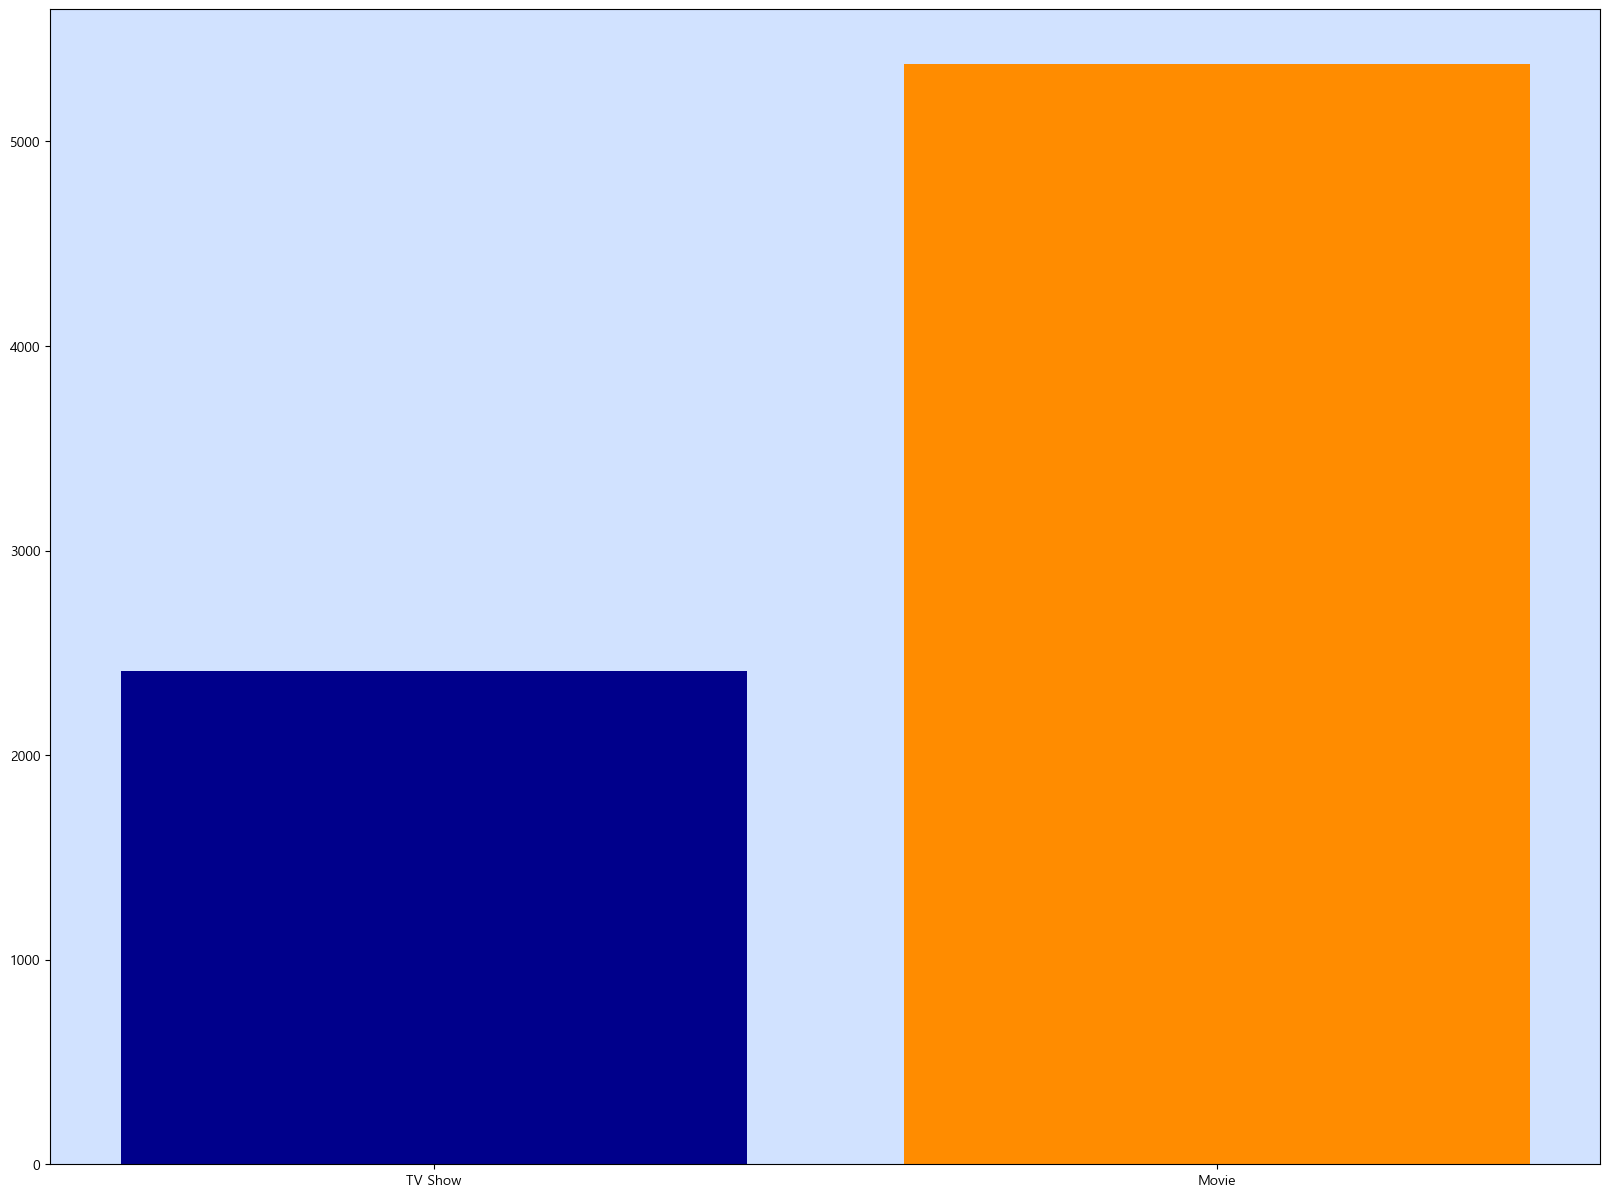

In [36]:
import matplotlib.pyplot as plt
type = ['TV Show','Movie']
colors = ['darkblue','darkorange']
plt.rc('font', family = 'Malgun Gothic')
fig=plt.figure(figsize = (20, 15))
ax = fig.add_subplot()
ax.patch.set_facecolor('#d1e2ff')
plt.bar(type, count, color = colors)
plt.show()


[참고]
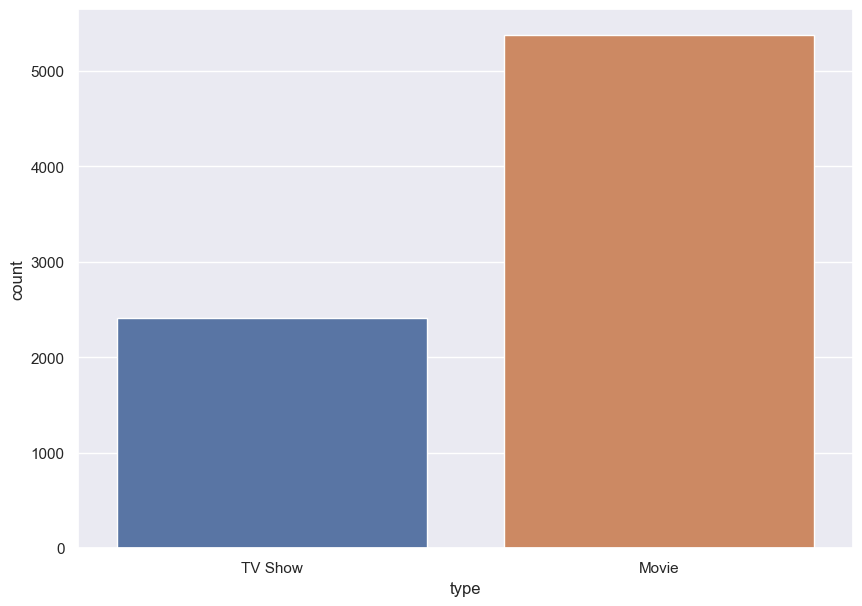

## 제작 국가별 수평 막대 그래프
- 결측 값 확인 및 결측 값을 포함한 레코드 삭제
- 2개 이상의 제작국가 값을 가지고 있는 레코드는 ‘,’를 기준으로 분류하여 카운팅 한다.
- 상위 10개국에 대한 막대그래프를 그린다.

In [184]:
display(netflix[['country']])
netflix[['country']].isnull().sum()
notnull = netflix[['country']].dropna()

exploded_countries = notnull['country'].str.split(',')
countries = exploded_countries.sum()
counts = countries.value_counts()
# new_counts = pandas.DataFrame(data=counts, index=None, columns=None, dtype=None, copy=False)

,country
0,Brazil
1,Mexico
2,Singapore
3,United States
4,United States
...,...
7782,"Sweden, Czech Republic, United Kingdom, Denmar..."
7783,India
7784,NaN
7785,Australia


AttributeError: 'list' object has no attribute 'value_counts'

[참고]
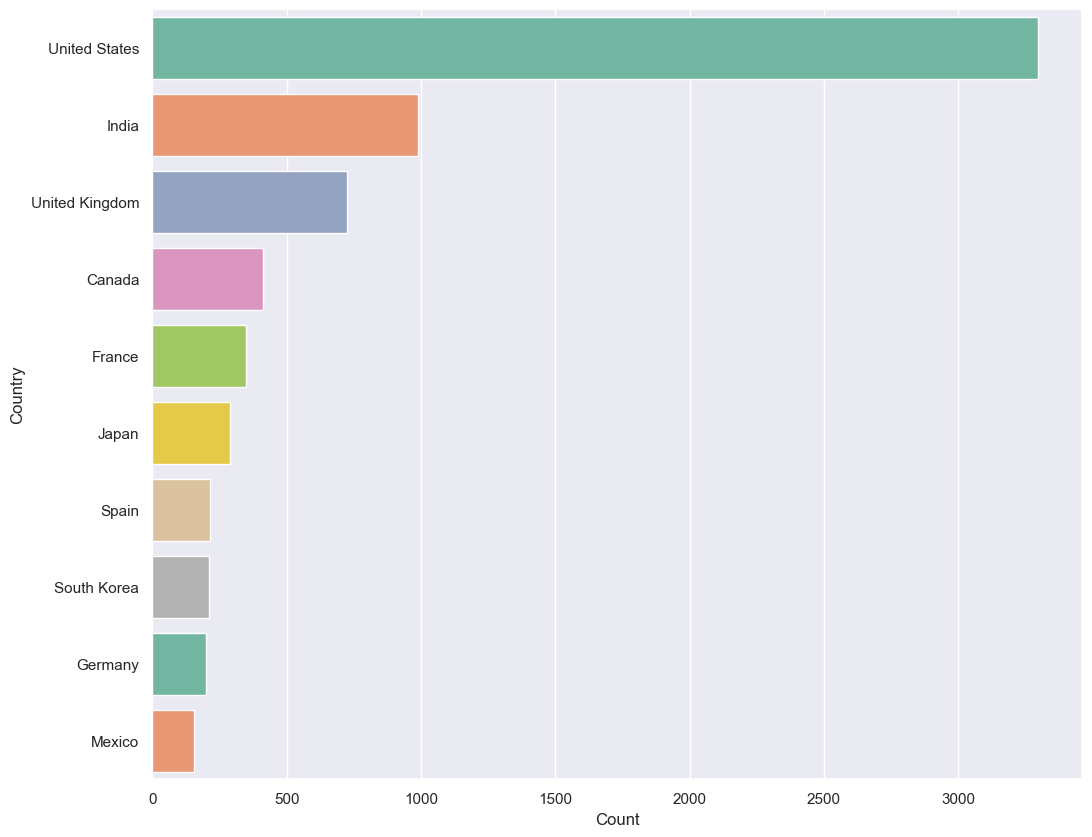

# 제목, 장르, 요약내용 특성 값을 기반으로 한 콘텐츠 기반 필터링 추천

## 데이터 전처리

### 추천 알고리즘 분석과 관련한 컬럼만 추출
- 추출 대상 컬럼: 'show_id', 'title', 'listed_in', 'description'    

In [107]:
netflix_df = netflix[['show_id','title','listed_in','description']]
display(netflix_df)

,show_id,title,listed_in,description
0,s1,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,7:19,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,23:59,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,9,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,21,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...
7782,s7783,Zozo,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Zubaan,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Zulu Man in Japan,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,Zumbo's Just Desserts,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


### DTM(Document Term Matrix) 생성
- title, listed_in, description 컬럼에 대해 피쳐 카운터 백터를 생성한다.
    - CounterVectorizer 또는 TfidfVectorizer 클래스를 이용한다.
    - nltk 라이브러리의 stopwords 패키지와 string 패키지의 punctuation을 합쳐 불용어 목록을 만들어 구두점 및 불용어를 제거한다.
    - title, listed_in, description 각 컬럼의 피처 벡터화한 결과를 **matrix_netflix_vocab = []** 리스트에 저장한다.

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string

netflix_df['title'].apply(lambda x: ''.join([k for k in x if k not in string.punctuation]))
count_vectorizer = CountVectorizer(min_df = 0, ngram_range = (1,2))
title_mat = count_vectorizer.fit_transform(netflix_df['title'])

netflix_df['listed_in'].apply(lambda x: ''.join([k for k in x if k not in string.punctuation]))
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_df=300)
listed_in_mat = tfidf_vect.fit_transform(netflix_df['listed_in'])

netflix_df['description'].apply(lambda x: ''.join([k for k in x if k not in string.punctuation]))
tfidf_vect = TfidfVectorizer(stop_words=stopwords.words('english'),ngram_range=(1,2), max_df=300)
description_mat = tfidf_vect.fit_transform(netflix_df['description'])

matrix_netflix_vocab = [title_mat,listed_in_mat,description_mat]

# 콘텐츠 유사도 측정

- title, listed_in, description 각 컬럼에 대해 피처 백터화 한 값을 이용하여 각각의 코사인 유사도를 산출하여 **matrix_netflix_sim = []** 리스트에 저장한다.

In [110]:
netflix_df.info()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

title_sim = cosine_similarity(title_mat, title_mat)
listed_in_sim = cosine_similarity(listed_in_mat, listed_in_mat)
description_sim = cosine_similarity(description_mat, description_mat)

matrix_netflix_sim = [title_sim,listed_in_sim,description_sim]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      7787 non-null   object
 1   title        7787 non-null   object
 2   listed_in    7787 non-null   object
 3   description  7787 non-null   object
dtypes: object(4)
memory usage: 243.5+ KB


- title, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스를 **netflix_sim_sorted_ind = []** 리스트에 저장한다.

In [140]:
import numpy as np
title_sim_sorted_idx = title_sim.argsort(axis=1)[:,::-1]
listed_in_sim_sorted_idx = listed_in_sim.argsort(axis=1)[:,::-1]
description_sim_sorted_idx = description_sim.argsort(axis=1)[:,::-1]

netflix_sim_sorted_ind = [title_sim_sorted_idx,listed_in_sim_sorted_idx,description_sim_sorted_idx]

# 유사도 필터링을 이용한 넷플릭스 콘텐츠 추천

- 추천 기준이 되는 콘텐츠의 제목으로 해당 콘텐츠의 netflix_df 데이터 프레임에서의 레코드 인덱스를 추출한다.
- 해당 인덱스로 sorted_ind_list 인자로 입력된 netflix_sim_sorted_ind 객체에서 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 후 리스트에 저장한다.
- 함수 매개변수
    - df: 넷플릭스 콘텐츠 정보 DataFrame
    - sorted_ind_list: title, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스 행렬을 저장한 리스트
    - title_name: 추천 기준이 되는 콘텐츠 제목 (해당 콘텐츠와 장르 유사도가 높은 콘텐츠를 추천)
    - top_n: 추천 콘텐츠 건수

In [171]:
# 완성된 함수가 아니며, 위 마크다운 셀의 내용을 참고하여 함수 안의 코드를 완성한다.
def find_sim_netflix(df, sorted_ind_list, title_name, top_n=10):
    target_netflix = df[df['title']==title_name]
    title_index = target_netflix.index.values[0]
    # 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 행렬을 저장할 리스트
    similar_indexes_list = sorted_ind_list[title_index,:]
    similar_indexes_list = similar_indexes_list.reshape(-1)
    # 데이터 프레임의 인덱스 값으로 사용하기 위해 1차원 데이터로 변환한다.
    return df.iloc[np.array(similar_indexes_list).flatten()]

In [172]:
similar_netflix = find_sim_netflix(netflix_df, netflix_sim_sorted_ind, 'Reply 1988',10)

TypeError: list indices must be integers or slices, not tuple

In [173]:
similar_netflix[['title']]

NameError: name 'similar_netflix' is not defined